# Forecasting Hourly Bike Rental Demand

__________________

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from datetime import date
import calendar

## Loading the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Since casual and registered variable together make up the 'count' feature, so we can drop both the columns for further processing.

In [4]:
train.drop(['casual','registered'],axis=1,inplace=True)

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Data Exploration

In [7]:
#shape of the train and test data
train.shape, test.shape

((10886, 10), (6493, 9))

In [8]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

In [9]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

We can see that there are 10 columns in the training dataset, whereas there are 9 columns in the test dataset. The missing column i.e., 'count' is our target variable and I will have to train my linear regression model to predict the variable.

In [10]:
# Information about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 808.0+ KB


From the above information we can infer that:

- type of the 'datetime' feature is character which we would have to change into a datetime data type
- season, holiday, working day and weather are shown as integers but they are actually categorical variables, so we will have  to convert them into 'character' data type.
- Apart from these, all the other features are in numeric in nature.

In [11]:
#Checking for null values in the train dataset
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

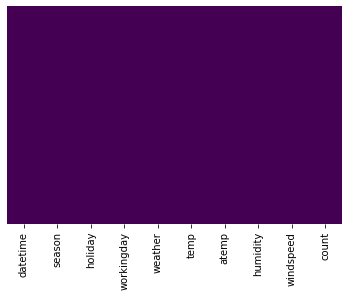

In [12]:
plt.figure(figsize=(6,4))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis');

Since there are no missing values in the train dataset so we don't have to further impute any data.

In [13]:
# Checking for missing values in the test dataset
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

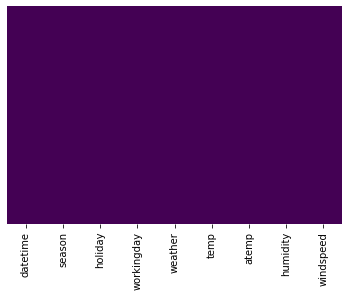

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis');

Similarly in the test dataset there are no missing values, hence no need for imputing any variable.

In [15]:
plt.style.use('ggplot')

In [16]:
# Descriptive stats of the train dataset
train.drop('count',axis=1).describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900


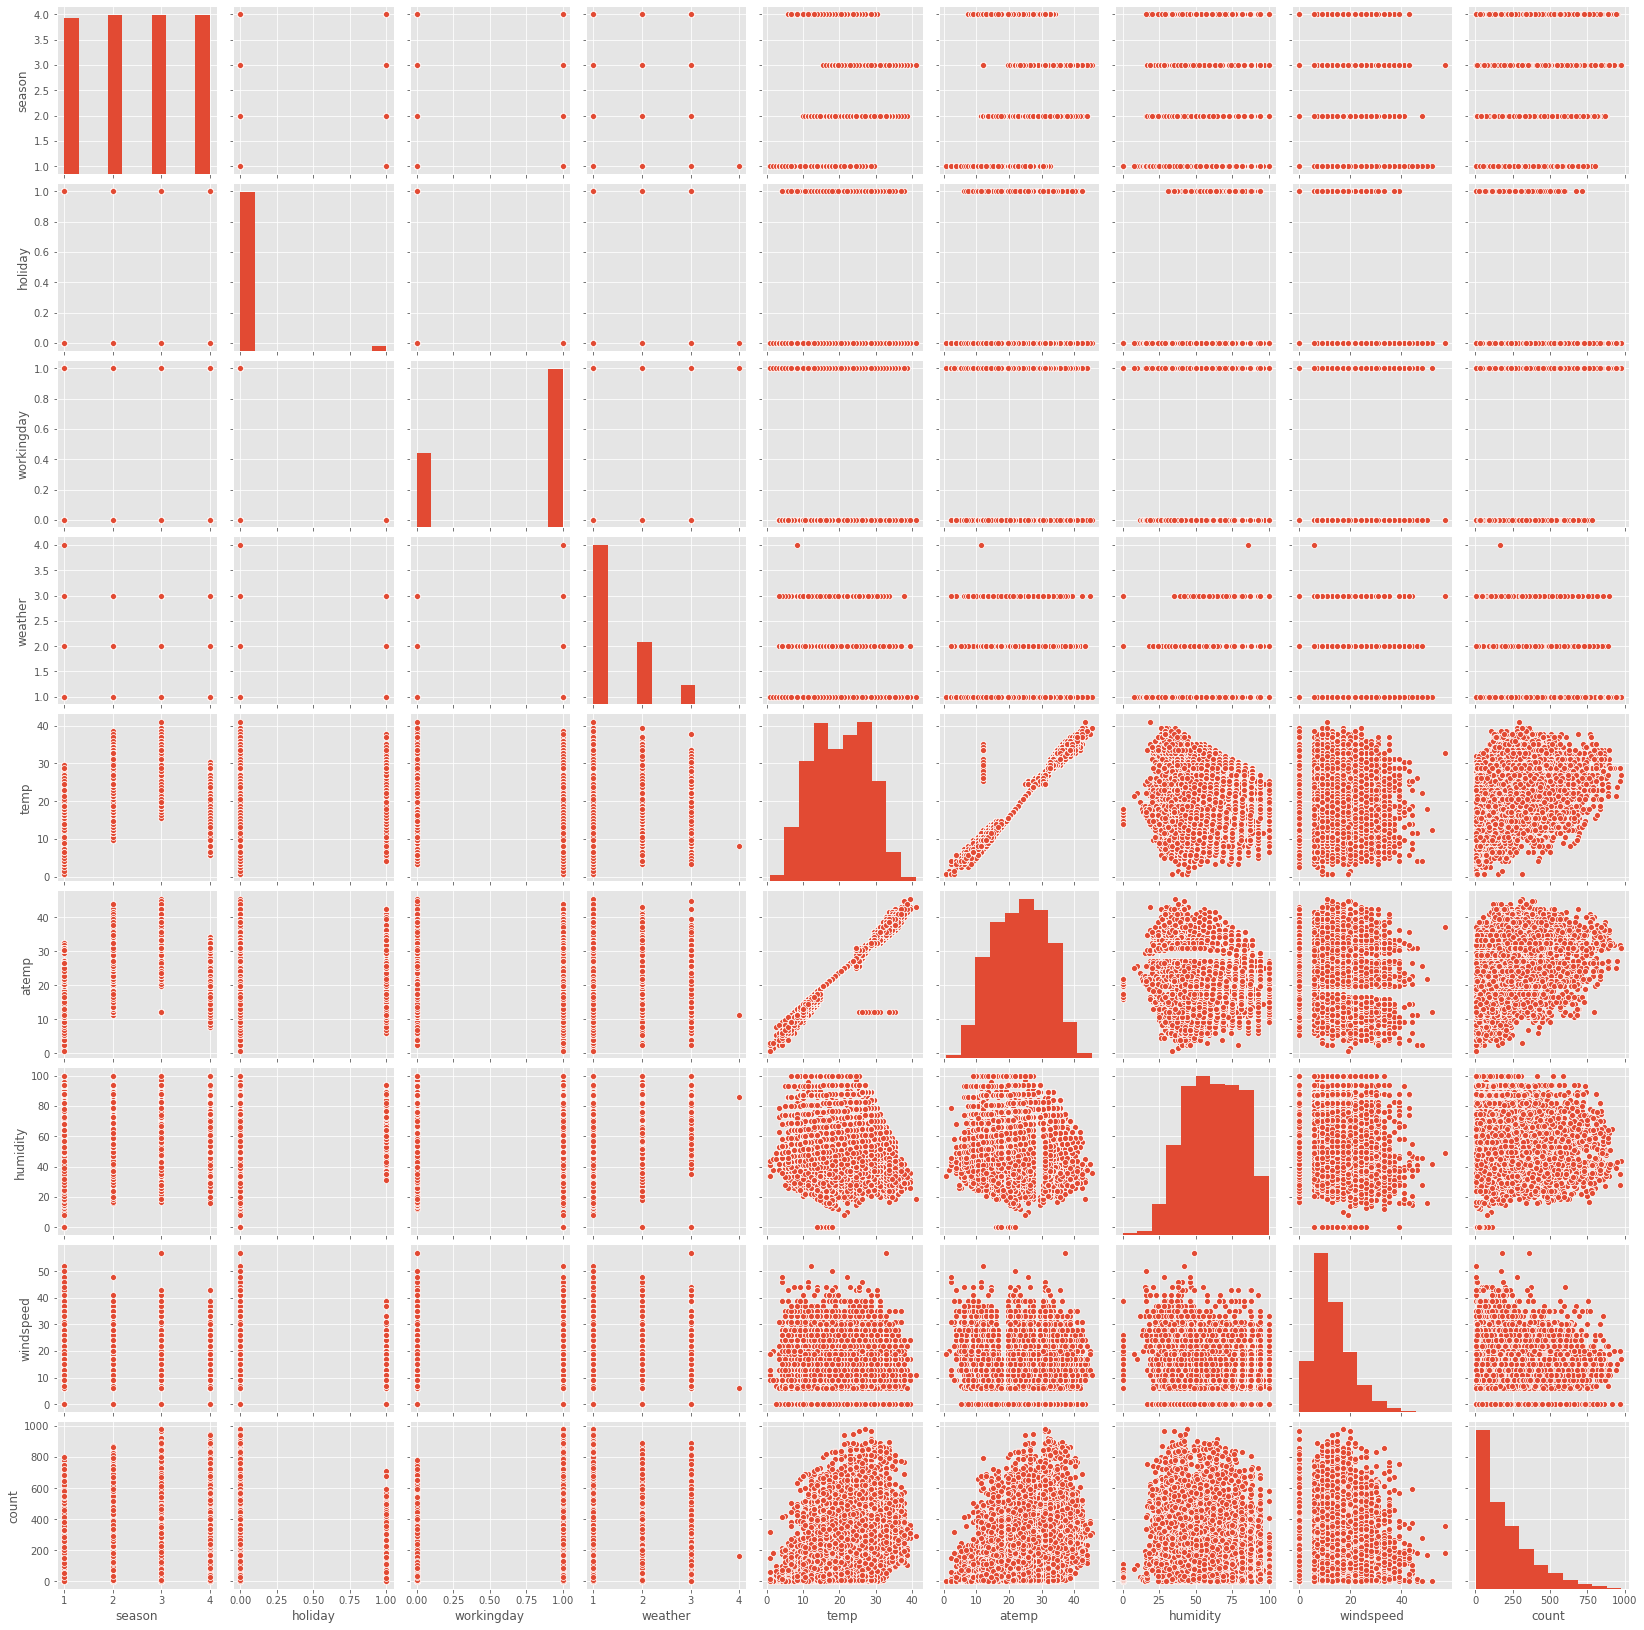

In [17]:
sns.pairplot(train);

## Exploratory Data Analysis

___________________________

## Univariate Analysis

#### Distribution of target variable 'count'

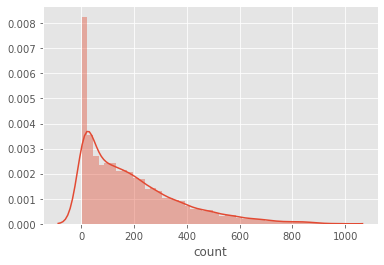

In [18]:
sns.distplot(train['count']);

From the above distribution plot of the 'count' variable we can infer that our target variable is right skewed and hence we have to take the log of the variable to check if the distribution becomes normal or not.

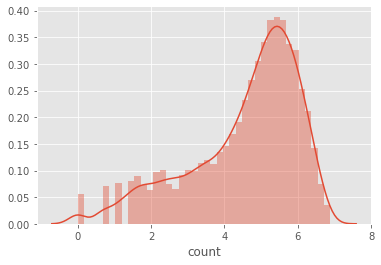

In [19]:
sns.distplot(np.log(train['count']));

## Bivariate Analysis

____________

#### Correlation matrix

Since 'season', 'holiday', 'workingday'and 'weather' are basically categorical variables and 'datetime' is string variable, so we will have to drop these columns in order to determine the correlation matrix.

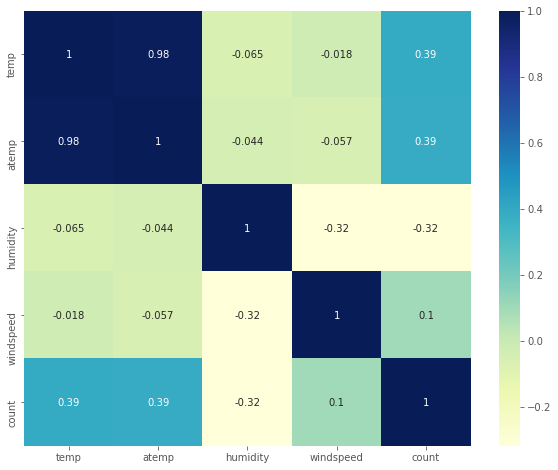

In [20]:
corrdata = train[["temp","atemp","humidity","windspeed","count"]]
corrmat = corrdata.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrmat, annot = True, cmap= 'YlGnBu');

From the above heatmap we can infer that:

1. 'temp' and 'humidity' have a positive and a negative correlation with 'count' respectively. Eventhough the correlation between them is not that strong but still it is little bit dependent on the 'temp' and 'humidity' variables.

2. 'windspeed' will not be a useful feature since it has got a very low correlation value with the demand (count) so we will have to drop this feature.

3. Since 'temp' and 'atemp' possess a very strong correlation among themselves, so one of these variable has to be dropped during model building otherwise there will be multi-collinearity in the data.

### Analyzing the datetime column

Since the vlaues in the 'datetime' column are of string type so we have to convert it into datetime format.

In [21]:
train['datetime'] = pd.to_datetime(train['datetime'])

In [22]:
test['datetime'] = pd.to_datetime(train['datetime'])

In [23]:
#checking the data type of the datetime column
type(train['datetime'][0]), type(test['datetime'][0])

(pandas._libs.tslibs.timestamps.Timestamp,
 pandas._libs.tslibs.timestamps.Timestamp)

#### Creating Year, Date, Month, Hour and Day of the week columns for the train dataset

In [24]:
train['year'] = train['datetime'].dt.year

In [25]:
train['month'] = train['datetime'].dt.month

In [26]:
train['date'] = train['datetime'].dt.date

In [27]:
train['hour'] = train['datetime'].dt.hour

In [28]:
train['day of the week'] = train['datetime'].dt.dayofweek

#### Creating Date, Month, Hour and Day of the week columns for the test dataset

In [29]:
test['year'] = test['datetime'].dt.year

In [30]:
test['month'] = test['datetime'].dt.month

In [31]:
test['date'] = test['datetime'].dt.date

In [32]:
test['hour'] = test['datetime'].dt.hour

In [33]:
test['day of the week'] = test['datetime'].dt.dayofweek

In [34]:
#converting day of the weeks to name of the day
dmap = {0:'Mon', 1:'Tue', 2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
train['day of the week'] = train['day of the week'].map(dmap)
test['day of the week'] = test['day of the week'].map(dmap)

In [35]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,date,hour,day of the week
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,2011-01-01,0,Sat
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,2011-01-01,1,Sat
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,2011-01-01,2,Sat
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,2011-01-01,3,Sat
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,2011-01-01,4,Sat


In [36]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,date,hour,day of the week
0,2011-01-01 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,2011-01-01,0,Sat
1,2011-01-01 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01-01,1,Sat
2,2011-01-01 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2011-01-01,2,Sat
3,2011-01-01 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01-01,3,Sat
4,2011-01-01 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,2011-01-01,4,Sat


In [37]:
# droppind the datetime column
train.drop('datetime',axis=1,inplace=True)
test.drop('datetime',axis=1,inplace=True)

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           10886 non-null  int64  
 1   holiday          10886 non-null  int64  
 2   workingday       10886 non-null  int64  
 3   weather          10886 non-null  int64  
 4   temp             10886 non-null  float64
 5   atemp            10886 non-null  float64
 6   humidity         10886 non-null  int64  
 7   windspeed        10886 non-null  float64
 8   count            10886 non-null  int64  
 9   year             10886 non-null  int64  
 10  month            10886 non-null  int64  
 11  date             10886 non-null  object 
 12  hour             10886 non-null  int64  
 13  day of the week  10886 non-null  object 
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


In [39]:
ymap = {2011:'0',2012:'1'}
train['year'] = train['year'].map(ymap)
test['year'] = test['year'].map(ymap)

In [40]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,date,hour,day of the week
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,2011-01-01,0,Sat
1,1,0,0,1,9.02,13.635,80,0.0,40,0,1,2011-01-01,1,Sat
2,1,0,0,1,9.02,13.635,80,0.0,32,0,1,2011-01-01,2,Sat
3,1,0,0,1,9.84,14.395,75,0.0,13,0,1,2011-01-01,3,Sat
4,1,0,0,1,9.84,14.395,75,0.0,1,0,1,2011-01-01,4,Sat


In [41]:
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,date,hour,day of the week
0,1,0,1,1,10.66,11.365,56,26.0027,0,1,2011-01-01,0,Sat
1,1,0,1,1,10.66,13.635,56,0.0000,0,1,2011-01-01,1,Sat
2,1,0,1,1,10.66,13.635,56,0.0000,0,1,2011-01-01,2,Sat
3,1,0,1,1,10.66,12.880,56,11.0014,0,1,2011-01-01,3,Sat
4,1,0,1,1,10.66,12.880,56,11.0014,0,1,2011-01-01,4,Sat


In [42]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           10886 non-null  int64  
 1   holiday          10886 non-null  int64  
 2   workingday       10886 non-null  int64  
 3   weather          10886 non-null  int64  
 4   temp             10886 non-null  float64
 5   atemp            10886 non-null  float64
 6   humidity         10886 non-null  int64  
 7   windspeed        10886 non-null  float64
 8   count            10886 non-null  int64  
 9   year             10886 non-null  object 
 10  month            10886 non-null  int64  
 11  date             10886 non-null  object 
 12  hour             10886 non-null  int64  
 13  day of the week  10886 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total

(None, None)

### Demand per day of the week

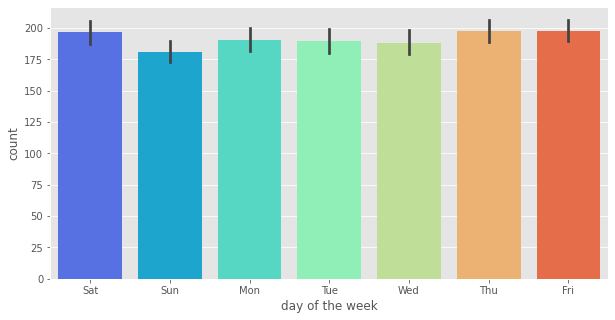

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data=train, x = 'day of the week', y = 'count', palette='rainbow');

We can infer that the demand of bike rentals were almost same for each day of the week. So this feature will not be useful in predicting the demand therefore we will have to drop this feature.

### Demand per month

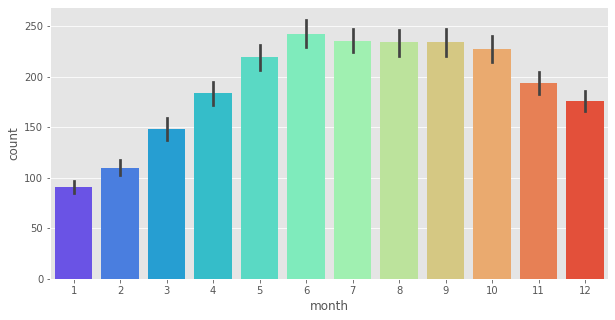

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(data=train, x='month', y = 'count', palette = 'rainbow');

We can see that demand for bike rentals was high during the months of summer and the demand drops during the months of winter.

### Demand per hour

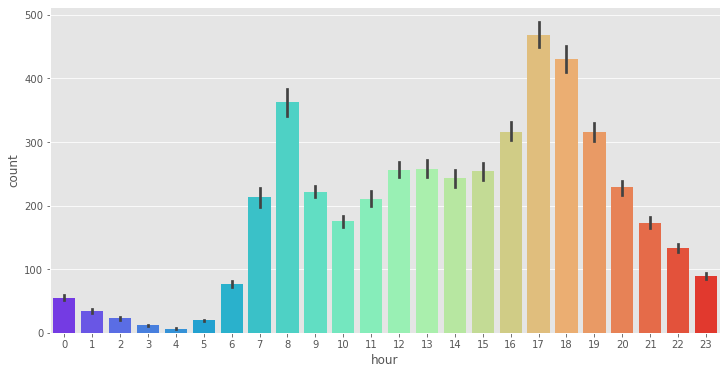

In [45]:
plt.figure(figsize=(12,6))
sns.barplot(data = train, x = 'hour', y = 'count', palette = 'rainbow');

From the above graph we can see that the demand for bike rentals were high during the office hours i.e., from 7 am to 6 pm and it was low during the non-working hours as it might be possible that most of the people use the bike rental services to reach their office premises or leave their premises during these hours.

### Demand per season

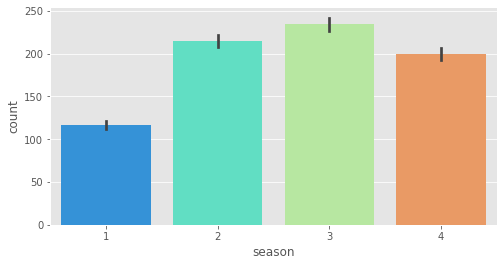

In [46]:
plt.figure(figsize = (8,4))
sns.barplot(data = train, x = 'season', y = 'count', palette = 'rainbow');

We can infer that demand was high during the summer and fall seasons while it drops during winter and spring season as the weather during these seasons might not be suitable for bike rentals.

### Demand as per holidays

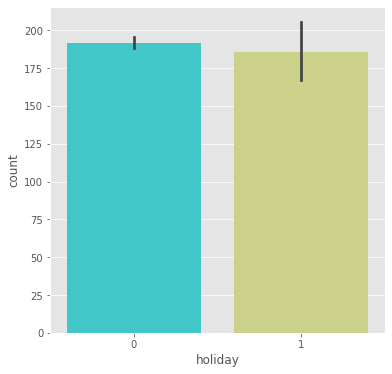

In [47]:
plt.figure(figsize=(6,6))
sns.barplot(data = train, x = 'holiday', y = 'count', palette = 'rainbow');

We can clearly see that demand was high during working days and low during holidays.

### Demand on working days

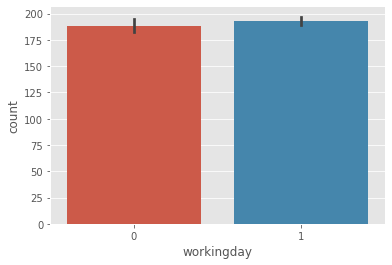

In [48]:
plt.figure(figsize=(6,4))
sns.barplot(data = train, x = 'workingday', y = 'count');

We can infer that whether it is a working day or not it doesn't affect the demand much as it remains almost the same both the time, therefore we will have to drop this column for getting better predictions from our linear regression model.

### Demand according to the weather

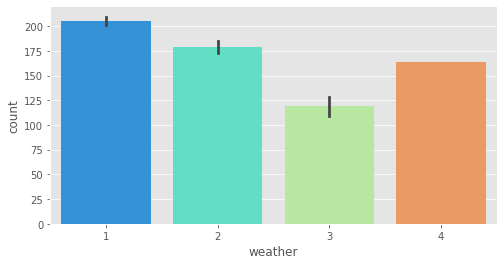

In [49]:
plt.figure(figsize=(8,4))
sns.barplot(data = train, x = 'weather', y = 'count', palette = 'rainbow');

From the above graph we can see that demand was high when the weather was clear and mist and drops when there is rain or snowy.

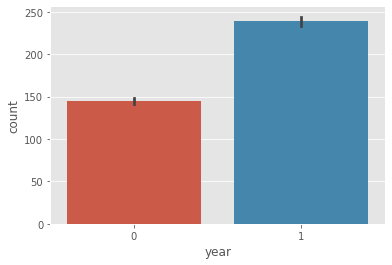

In [50]:
plt.figure(figsize=(6,4))
sns.barplot(data = train, x = 'year', y = 'count');

Since we have data of only two years so we cannot infer much from it and hence we will have to drop this column.

### Temperature vs Demand

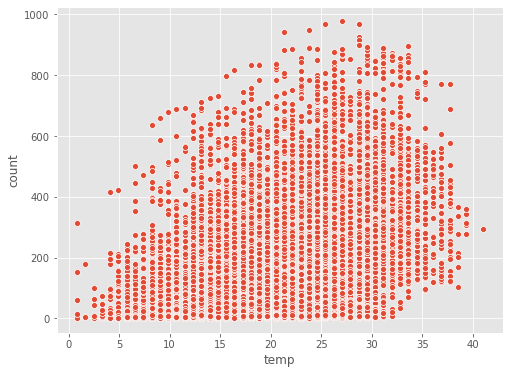

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = train, x = 'temp', y = 'count');

We can say that as the temperature increases the demand also increases.

## Demand vs aTemp

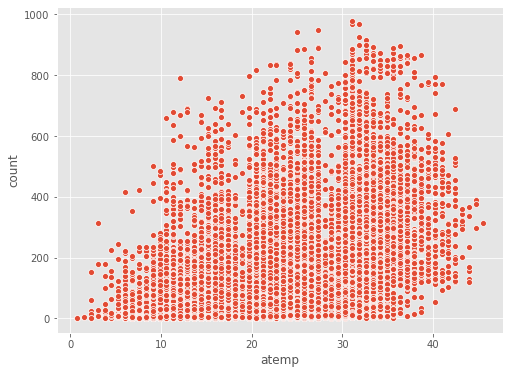

In [52]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = train, x = 'atemp', y = 'count');

We can see that this plot is almost similar to the previous plot of temperature and demand which means there is a high correlation between temp and atemp features which is quite understandable.

### Humidity vs Demand

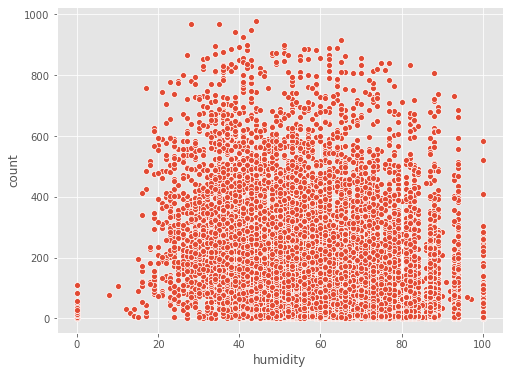

In [53]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = train, x = 'humidity', y='count');

We can infer that the humidity is not much correlated to the demand.

### Windspeed vs Demand

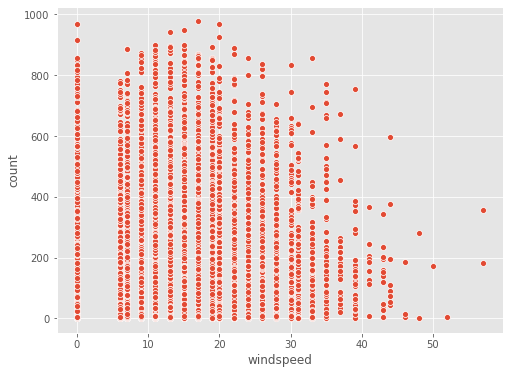

In [54]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = train, x = 'windspeed', y='count');

Since windspeed has a very low correlation with the demand so it does not affect the demand much.

_______________

In [55]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,date,hour,day of the week
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,2011-01-01,0,Sat
1,1,0,0,1,9.02,13.635,80,0.0,40,0,1,2011-01-01,1,Sat
2,1,0,0,1,9.02,13.635,80,0.0,32,0,1,2011-01-01,2,Sat
3,1,0,0,1,9.84,14.395,75,0.0,13,0,1,2011-01-01,3,Sat
4,1,0,0,1,9.84,14.395,75,0.0,1,0,1,2011-01-01,4,Sat


## Model Building

- We will drop the day of the week, date and year variable as we have already extracted features from this variables.
- We will also drop the atemp variable as we saw that it is highly correlated with the temp variable.
- We will also have to drop the workingday and windspeed variables as it does not affect the demand much.

In [57]:
train.drop(['atemp','date','day of the week','year','windspeed','workingday'], axis=1, inplace=True)

In [58]:
test.drop(['atemp','date','day of the week','year','windspeed','workingday'], axis=1, inplace=True)

In [59]:
train.head()

,season,holiday,weather,temp,humidity,count,month,hour
0,1,0,1,9.84,81,16,1,0
1,1,0,1,9.02,80,40,1,1
2,1,0,1,9.02,80,32,1,2
3,1,0,1,9.84,75,13,1,3
4,1,0,1,9.84,75,1,1,4


In [60]:
train.tail()

,season,holiday,weather,temp,humidity,count,month,hour
10881,4,0,1,15.58,50,336,12,19
10882,4,0,1,14.76,57,241,12,20
10883,4,0,1,13.94,61,168,12,21
10884,4,0,1,13.94,61,129,12,22
10885,4,0,1,13.12,66,88,12,23


In [61]:
# creating dummy variables of the train dataset
season = pd.get_dummies(train['season'],prefix='season',drop_first=True)
weather = pd.get_dummies(train['weather'],prefix='weather',drop_first=True)
holiday = pd.get_dummies(train['holiday'],prefix='holiday',drop_first=True)
month = pd.get_dummies(train['month'],prefix='month',drop_first=True)
hour = pd.get_dummies(train['hour'],prefix='hour',drop_first=True)
train = pd.concat([train,season,weather,holiday,month,hour],axis=1)
train.drop(['season','weather','holiday','month','hour'], axis=1,inplace=True)
train.head()

,temp,humidity,count,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
#creating dummy variables of the test dataset
# creating dummy variables of the train dataset
season = pd.get_dummies(test['season'],prefix='season',drop_first=True)
weather = pd.get_dummies(test['weather'],prefix='weather',drop_first=True)
holiday = pd.get_dummies(test['holiday'],prefix='holiday',drop_first=True)
month = pd.get_dummies(test['month'],prefix='month',drop_first=True)
hour = pd.get_dummies(test['hour'],prefix='hour',drop_first=True)
test = pd.concat([test,season,weather,holiday,month,hour],axis=1)
test.drop(['season','weather','holiday','month','hour'], axis=1,inplace=True)
test.head()

,temp,humidity,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,month_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,10.66,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.66,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10.66,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10.66,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10.66,56,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X = train.drop('count',axis=1)
y = np.log(train['count'])

In [64]:
X.head()

,temp,humidity,season_2,season_3,season_4,weather_2,weather_3,weather_4,holiday_1,month_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,80,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,80,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### splitting our data

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size = 0.3,random_state=101)

### Training the Linear Regression Model

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
lm = LinearRegression()

In [69]:
#fitting the training data
lm.fit(X_train,y_train)

LinearRegression()

In [70]:
#printing the intercept
print(lm.intercept_)

2.8256438691548427


In [71]:
#printing the coefficient
lm.coef_

array([ 3.78671725e-02, -3.74310336e-03,  2.54479965e+10,  4.84299818e+10,
       -5.52668020e+09, -3.86519824e-02, -5.60317345e-01, -7.79689997e+08,
        1.42681376e-02,  1.74215678e-01,  2.26300525e-01, -2.54479965e+10,
       -2.54479965e+10, -2.54479965e+10, -4.84299818e+10, -4.84299818e+10,
       -4.84299818e+10,  5.52668020e+09,  5.52668020e+09,  5.52668020e+09,
       -5.90459434e-01, -1.18999001e+00, -1.71195969e+00, -2.03251258e+00,
       -9.68106933e-01,  2.75196898e-01,  1.29208634e+00,  1.88575661e+00,
        1.54708404e+00,  1.19477731e+00,  1.34769493e+00,  1.51704551e+00,
        1.48528250e+00,  1.36730797e+00,  1.43724990e+00,  1.70555420e+00,
        2.13093294e+00,  2.03080312e+00,  1.76569914e+00,  1.48080663e+00,
        1.22205900e+00,  1.00702292e+00,  5.83966854e-01])

In [72]:
cdf = pd.DataFrame(lm.coef_, X.columns, columns = ['Coefficients'])

In [73]:
cdf

,Coefficients
temp,3.786717e-02
humidity,-3.743103e-03
season_2,2.544800e+10
season_3,4.842998e+10
season_4,-5.526680e+09
weather_2,-3.865198e-02
weather_3,-5.603173e-01
weather_4,-7.796900e+08
holiday_1,1.426814e-02
month_2,1.742157e-01


Now that we have a trained linear regression model with us. We will now make prediction on the X_val set and check the performance of our model. Since the evaluation metric for this problem is RMSLE, we will define a model which will return the RMSLE score.

In [82]:
# Predictions
predictions = abs(lm.predict(X_val))

In [83]:
predictions

array([5.81597703, 5.4173507 , 3.82626043, ..., 5.12106553, 3.98408474,
       1.2657798 ])

### Evaluating the regression

In [86]:
from sklearn import metrics

In [87]:
# Mean Absolute Error
metrics.mean_absolute_error(y_val, predictions)

238729.83645112315

In [88]:
# Mean Squared error
metrics.mean_squared_error(y_val,predictions)

186134866948433.0

In [89]:
# Root Mean Squared Log Error
np.sqrt(metrics.mean_squared_log_error(y_val,predictions))

0.3730456625418565

We can see that our RMSLE score is very low which indicates that our model has predicted the values almost the same as the validation set.

Let's now make predictions for the test dataset which was our main goal.

In [94]:
test_prediction = abs(lm.predict(test))

In [96]:
final_prediction = np.exp(test_prediction)

<ipython-input-96-1255a8b9f055>:1: RuntimeWarning: overflow encountered in exp
  final_prediction = np.exp(test_prediction)


In [100]:
final_prediction = np.round(final_prediction)

In [101]:
final_prediction

array([ 20.,  11.,   6., ..., 139., 216., 189.])

________________________

## Decision Tree

In [102]:
from sklearn.tree import DecisionTreeRegressor

In [103]:
dt_reg = DecisionTreeRegressor(max_depth=5)

Fitting the tree model

In [104]:
dt_reg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5)

Predicting the validation set

In [105]:
predict = dt_reg.predict(X_val)

In [106]:
predict

array([5.12889547, 5.12889547, 5.12889547, ..., 5.12889547, 5.12889547,
       0.27465307])

In [107]:
# calculating rmsle of the predicted values
np.sqrt(metrics.mean_squared_log_error(y_val,predict))

0.22601862326540967

The rmsle value decreased to 0.226. This is a decent score. Let's make predictions for the test dataset.

In [108]:
test_predict = dt_reg.predict(test)

In [109]:
final_predict = np.exp(test_predict)

In [110]:
final_predict = np.round(final_predict)

In [111]:
final_predict

array([169.,  22.,  14., ..., 169., 169., 169.])

In [112]:
submission = pd.DataFrame()

In [117]:
submission['count'] = final_predict

In [118]:
submission.to_csv('sample submission.csv',header=True,index=False)